# Alzheimers Progression Classifier using Coronal MRI

**Authors: Jacob Heyman, Mitch Krieger**
***
## Overview

### Business Problem

Current methods for diagnosing Alzheimers disease in patients displaying early signs of dementia are expensive, risky and require expert analysis.  Recent studies have shown that using MRI imaging to visualize neurodegeneration can be an alternative method of diagnosis.  While this method decreases expense and risk, MRI imaging for tissue atrophy still requires visual analysis, resulting in potential human error.  Using machine learning algorithms we plan on creating a classifying model that can be used to classify the progression of demensia in AD patients and be used as a primary diagnostic tool for further medical intervention.  In this project we aim to answer the following questions:

- What are some of the distinct features of the four classes of dementia?       
- Can we create a model that accuratly classifies AD MRI images?
- What model and method best reduces the number of false positive when classifying images?

### Data Understanding

#### Import relevant libraries and packages

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, shutil
import numpy as np
from math import ceil
import itertools
from helper_functions import *
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score
from skimage.feature import hog
from skimage import exposure
np.random.seed(123)

import keras
from keras import models
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

#### Read in Train Dataset for EDA

Data comes from a Kaggle dataset and consists of a total of 64000 images pre-separated into test and train sets belonging to four different classes, each with a different images of brain MRIs at progressive stages of dementia (Non-Demented, Very Mild, Mild and Moderately Demented).

In [2]:
directory = 'Alzheimer_s Dataset/'
test_directory = 'Alzheimer_s Dataset/test/'
train_directory = 'Alzheimer_s Dataset/train/'

In [4]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 5121, 
        seed = 123)

# separate images from labels
train_images, train_labels = next(data_train)
print('Found Classes: ',data_train.class_indices)

Found 5122 images belonging to 4 classes.
Found Classes:  {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


#### Visualize Class Balance

Simple bar plot shows high class imbalance particularly for moderately and mildy demented classes. This is not unusual for medical data because of manual labor required by medical experts and the rare nature of the minority class compared to the majority. Later, we will attempt to address using image augmentation.

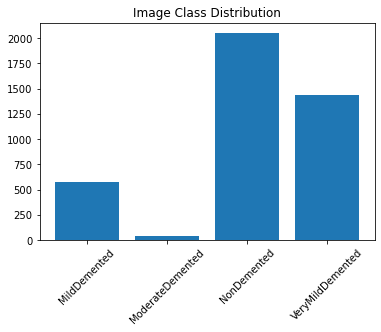

In [118]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(train_labels))
plt.xticks(rotation=45)
plt.title('Image Class Distribution');
plt.savefig('./images/class_balance.png')

#### Visualize 9 sample images

These sample 9 coronal brain MRI images show slight differences between classes that are difficult to detect for the average layperson. Small but noticable difference are the level of atrophy (black areas) around the edges of the cerebral cortex (outer layer of the brain)

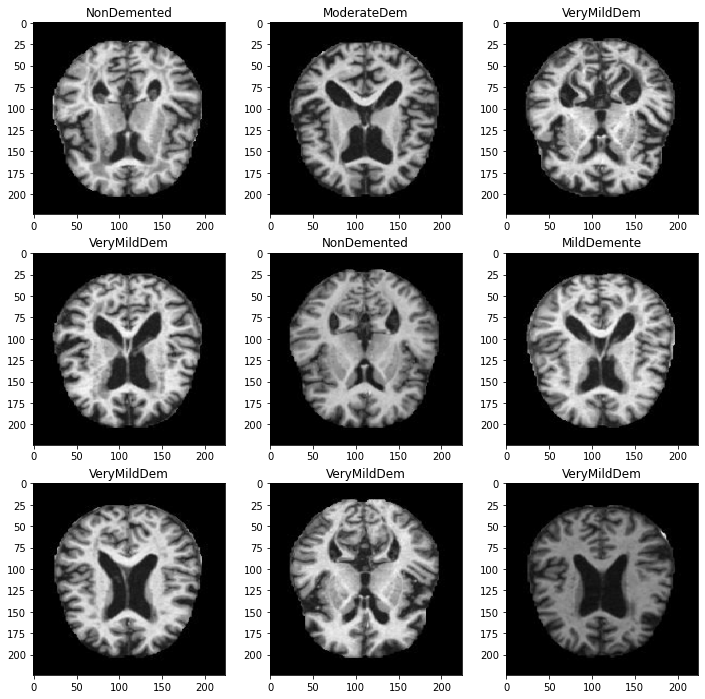

In [6]:
label_names = np.apply_along_axis(get_label,1,train_labels)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images[i])
  plt.gca().set_title(label_names[i])
plt.show()

#### Separate classes for EDA

In [7]:
#isolated milddemented class images for eda
data_mild = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['MildDemented'])

data_moderate = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['ModerateDemented'])

data_NonD = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2560, 
        seed = 123,
        classes= ['NonDemented'])

data_veryMild = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 1792, 
        seed = 123,
        classes= ['VeryMildDemented'])

mild_images, mild_labels = next(data_mild)
moderate_images, moderate_labels = next(data_moderate)
NonD_images, NonD_labels = next(data_NonD)
veryMild_images, veryMild_labels = next(data_veryMild)

Found 717 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 2561 images belonging to 1 classes.
Found 1792 images belonging to 1 classes.


#### Create mean images of each class to identify distinctive features

By taking the mean of each class, we see below that as people become more demented, brain atrophy in the cerebral cortext (outer layers) of the brain becomes worse. 

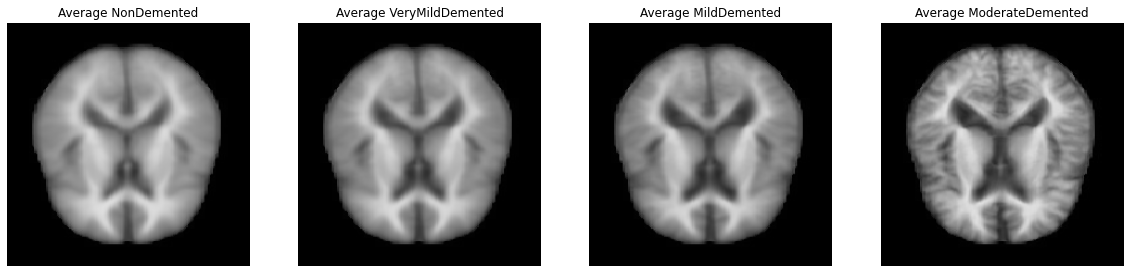

In [89]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))

NonD_mean = find_mean_img(NonD_images, ax[0], 'NonDemented')
veryMild_mean = find_mean_img(veryMild_images, ax[1],  'VeryMildDemented')
mild_mean = find_mean_img(mild_images,  ax[2], 'MildDemented')
Moderate_mean = find_mean_img(moderate_images,  ax[3], 'ModerateDemented')

plt.savefig('./images/mean.png')

#### Subtract Moderate from Non-Demented mean to obtain contrast

By subtracting the moderate mean image from the non-demented mean image, we can obtain the largest areas of difference (identified by white). Further confirms that more demented brains have atrophy in these areas. 

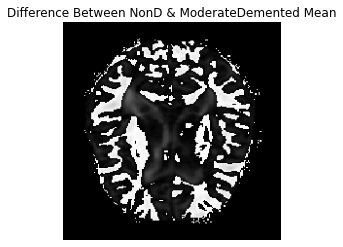

In [90]:
contrast_mean = NonD_mean - Moderate_mean
plt.imshow((contrast_mean*255).astype(np.uint8))
plt.title(f'Difference Between NonD & ModerateDemented Mean')
plt.axis('off')
plt.savefig('./images/contrast.png')
plt.show()

#### Standarad Deviation of classes

By finding the stanard deviation of the images we can identify areas with large variability. The moderately demended images have more variablity than others (signaled by brighter whites) indicating that it may be difficult for models to identify that class.

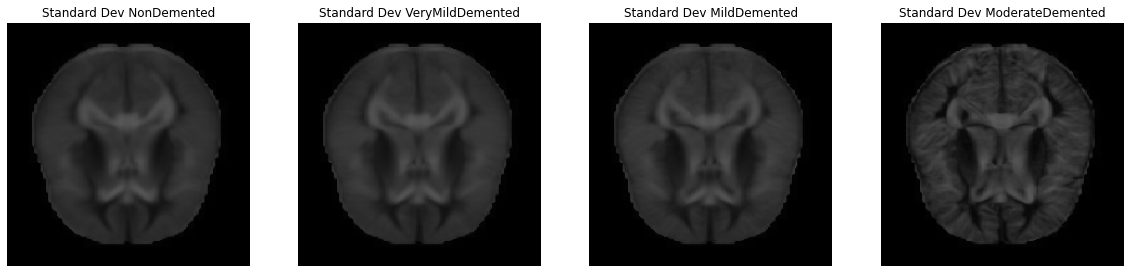

In [91]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))

NonD_std = find_std_img(NonD_images, ax[0], 'NonDemented')
veryMild_std = find_std_img(veryMild_images, ax[1],'VeryMildDemented')
mild_std = find_std_img(mild_images, ax[2],'MildDemented')
Moderate_std = find_std_img(moderate_images,ax[3], 'ModerateDemented')

plt.savefig('./images/std.png')

#### Performing PCA to generate Eiganimages

By identifying the number of principle components in our data, we can reconstruct eiganimages to generate images that in theory display the features that explain the most variance in the data. Below we performed PCA for 70% of the variance on non-demented images, moderately demended images, and the entire dataset. This yeilded a high number of priciple components, the first few of which did not explain a high amount of variance, indicating that there may be many features contributing the to variance.

In [11]:
non_eigan = eigenimages(NonD_images, 'NORMAL')
moderate_eigan= eigenimages(moderate_images, 'Moderate')

Number of PC:  81
Number of PC:  5


In [13]:
eigan_data = eigenimages(train_images, 'All')

Number of PC:  100


In [94]:
#first 10 PCs only explain 46.7% of the data
np.cumsum(eigan_data.explained_variance_ratio_[:10])

array([0.198734  , 0.2954595 , 0.36909124, 0.39565012, 0.4159412 ,
       0.43092334, 0.44355318, 0.45249155, 0.46052957, 0.46779522],
      dtype=float32)

The Eiganimages below show the explained variance in image form but unlike eiganfaces, are hard to decipher without deeper domain knowlege.

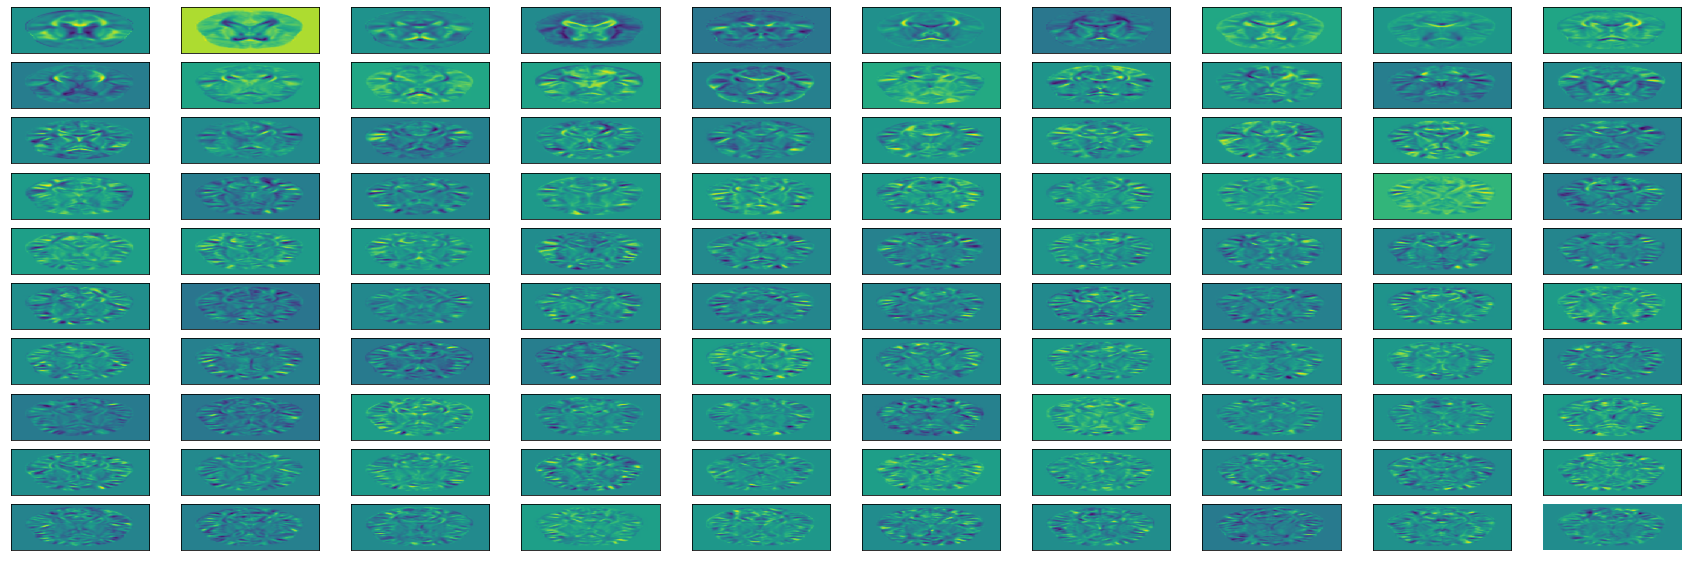

<Figure size 432x288 with 0 Axes>

In [92]:
eigan_images = plot_pca(eigan_data)
plt.savefig('./images/eigan.png')

#### Histogram of oriented Gradients

Because eiganimages & PCA were difficult to decipher, we turned to a Histogram of oriented gradients (HOG) which generates plots of the gradients of localized portions of images. In other words, it shows how quickly the brightness of the pixels are changing and in what direction. Hogs are good for detecting important features that a computer might pick up on because of quick changes in gradient. From the below plots of the HOGs for Nondemented and moderately demented mean images, we can see that the pixel gradient of modertately demented brains changes much quicker than that of nondemented. This further confirms the notion that atrophy of brain tissue is a major phenotye of Altzheimers Disease. 

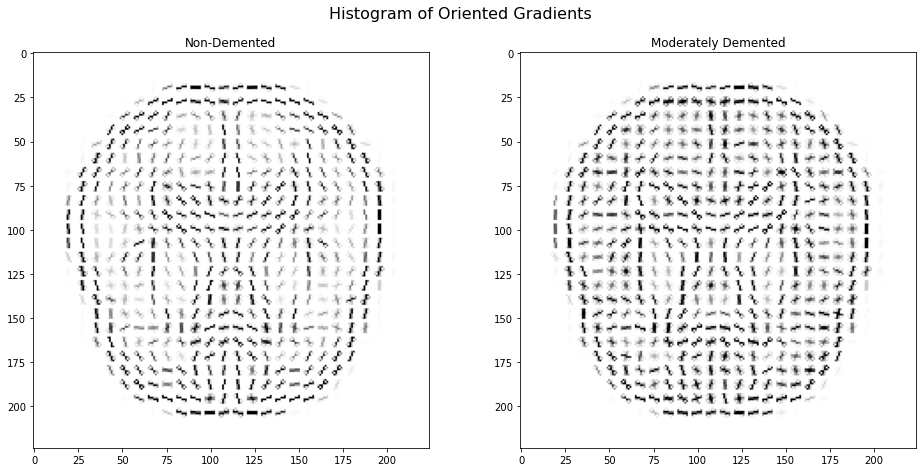

In [88]:
#histogram of oriented gradients
fd_NonD, NonD_hog = hog(NonD_mean, orientations=8, pixels_per_cell=(8,8),
                       cells_per_block=(3,3),visualize=True)
fd_moderate, moderate_hog = hog(Moderate_mean, orientations=8, pixels_per_cell=(8,8),
                       cells_per_block=(3,3),visualize=True)

NonD_hogs = exposure.rescale_intensity(NonD_hog, in_range=(0,0.04))
moderate_hogs = exposure.rescale_intensity(moderate_hog, in_range=(0,0.04))


fig = plt.figure(figsize=(16,16))
fig.suptitle('Histogram of Oriented Gradients', x=.5,y=0.92,fontsize=16)
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(NonD_hogs, cmap='binary')
ax1.set_title('Non-Demented')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(moderate_hogs, cmap='binary')
ax2.set_title('Moderately Demented')

plt.savefig('./images/hog.png')

## Create Validation and Test Sets

In [17]:
data_genorator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

data_train= data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 4098, 
        seed = 123)

data_valid = data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'validation',
        target_size=(224, 224), 
        batch_size = 1023, 
        seed = 123)

data_test= ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

valid_images, valid_labels = next(data_valid)

Found 4099 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Augmenting Images

Due to high class imbalance, we will use image augmentation to increase our minority class presence:

In [18]:
#Augmeneting minority classes

#create image generators
hflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
vflip = ImageDataGenerator(rescale=1./255,vertical_flip=True)
hshift = ImageDataGenerator(rescale=1./255,width_shift_range=(-40,40))
vshift = ImageDataGenerator(rescale=1./255,height_shift_range=(-40,40))
rotation = ImageDataGenerator(rescale=1./255,rotation_range=90)
shear = ImageDataGenerator(rescale=1./255,shear_range=45)
hvflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True)
bright = ImageDataGenerator(rescale=1./255,brightness_range=(.2,1))
bright_rot = ImageDataGenerator(rescale=1./255,brightness_range=(.2,1),rotation_range=90)


augmentors = [hflip,vflip,hshift,vshift,rotation,shear,hvflip,bright,bright_rot]

#iterate through augmentors and generate augmented image sets
mild_augmented = []
mod_augmented = []

for augmentor in augmentors[:2]:

    aug_mild = augmentor.flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['MildDemented'])
    
    mild_augmented.append(aug_mild)

for augmentor in augmentors:    

    aug_moderate = augmentor.flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['ModerateDemented'])
    
    mod_augmented.append(aug_moderate)
    

#extract image matricies from generators and separate out images matricies from labels
data_mild_aug = [next(mild) for mild in mild_augmented]  
data_mod_aug = [next(mod) for mod in mod_augmented]

mild_aug_images = [images[0] for images in data_mild_aug]
mod_aug_images = [images[0] for images in data_mod_aug]

#concat all matricies together
concat_mild_images = np.vstack(mild_aug_images)
concat_mod_images = np.vstack(mod_aug_images)

#create label matricies 
concat_mild_labels = np.array([[1.,0.,0.,0.] for i in range(len(concat_mild_images))])
concat_mod_labels = np.array([[0.,1.,0.,0.] for i in range(len(concat_mod_images))])

#concat back to original training data
train_images_aug = np.concatenate((train_images,concat_mild_images,concat_mod_images))
train_labels_aug = np.concatenate((train_labels,concat_mild_labels,concat_mod_labels))

Found 717 images belonging to 1 classes.
Found 717 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 52 images belonging to 1 classes.


#### Revisualize new class balance

There still is significant class imbalance, despite the added images. Without additional data, this may affect model quality.

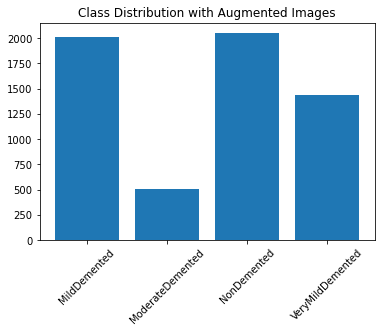

In [120]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(train_labels_aug))
plt.xticks(rotation=45)
plt.title('Class Distribution with Augmented Images')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('./images/class_balance_aug.png')

## Create first classifier model using basic nerual net

To get a baseline model, we will create a basic nerual network and use unrowing to run our images through the model.We are using Recall and Accuracy to evaluate quaity of the model to try to minimize false positives of severe Altzheimer's cases.

**Unrowing:**

In [20]:
x_train = train_images.reshape(4098,150528)

x_train_aug = train_images_aug.reshape(6000,150528)

x_test = test_images.reshape(1279,150528)

x_valid = valid_images.reshape(1023,150528)

## First Baseline Model

A basic Neural Network with 3 layers, first attempt will we without image augmentation. We will use softmax for our activation function in the final layer due to the multiple classes presented in the problem.

In [112]:
batch_size = 15
num_classes = 4
epochs = 30

#model architecture
model = Sequential()

model.add(Dense(30, activation='relu',input_shape=(150528,),use_bias=True,bias_initializer='zeros'))

model.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))

model.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))

model.add(Dense(num_classes, activation='softmax'))

#model output
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy',Recall()])

#early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

history = model.fit(x_train, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks= [early_stop],
                    validation_data=(x_valid, valid_labels))
score = model.evaluate(x_test, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[2])
print('Test Accuracy', score[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 30)                4515870   
_________________________________________________________________
dense_43 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_44 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 124       
Total params: 4,517,854
Trainable params: 4,517,854
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
274/274 [==============================] - 14s 51ms/step - loss: 2.2223 - accuracy: 0.5327 - recall_15: 0.4941 - val_loss: 1.7726 - val_accuracy: 0.3333 - val_recall_15: 0.3255
Epoch 2/30
274/274 [==============================] -

##### Visualizing Neural Net Results

Train set metrics rise (and loss decreases) while validadtion set metrics stay relatively the same, could indicate trending towards overfitting.

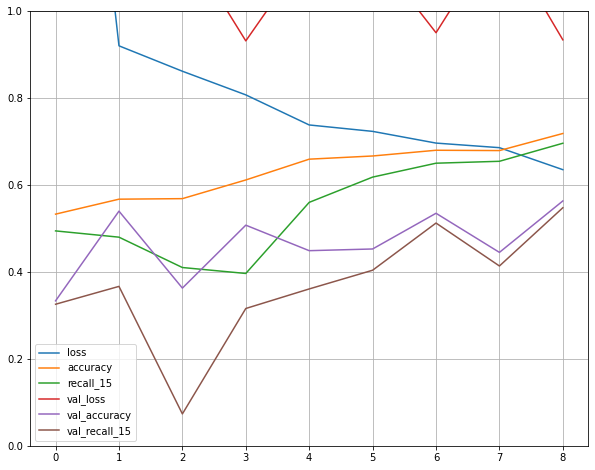

In [113]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Because our training set without augmentation is about 50% Nondemented, this model performs a tad bit better than a random guess. This can be seen using the confusion matrix:

Normalized confusion matrix
[[0.08938547 0.         0.44692737 0.46368715]
 [0.         0.         0.33333333 0.66666667]
 [0.         0.         0.896875   0.103125  ]
 [0.015625   0.         0.70982143 0.27455357]]


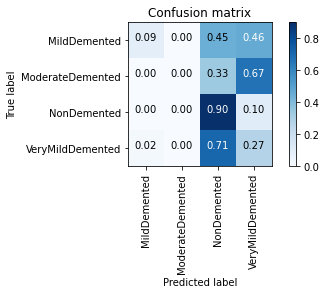

In [114]:
y_pred = model.predict_classes(x_test)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

Confusion matrix confirms that model is mostly classifying images as the majority class (nondemented).

### Basic Model with Augmented Images

Rerun previous model with augmented data, to see if the model fares better

In [95]:
batch_size = 15
num_classes = 4
epochs = 40


model_aug = Sequential()

model_aug.add(Dense(30, activation='relu',input_shape=(150528,),use_bias=True,bias_initializer='zeros'))

model_aug.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))

model_aug.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))

model_aug.add(Dense(num_classes, activation='softmax'))

model_aug.summary()

model_aug.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy',Recall()])

early_stop = EarlyStopping(monitor='val_loss',patience=4,verbose=1,mode='auto')

history_aug = model.fit(x_train_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks= [early_stop],
                    validation_data=(x_valid, valid_labels))
score = model_aug.evaluate(x_test, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[2])
print('Test Accuracy', score[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 30)                4515870   
_________________________________________________________________
dense_35 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_36 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 124       
Total params: 4,517,854
Trainable params: 4,517,854
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
400/400 [==============================] - 12s 30ms/step - loss: 1.2854 - accuracy: 0.3400 - recall: 0.0000e+00 - val_loss: 1.2329 - val_accuracy: 0.1398 - val_recall: 0.0000e+00
Epoch 2/40
400/400 [==============================]

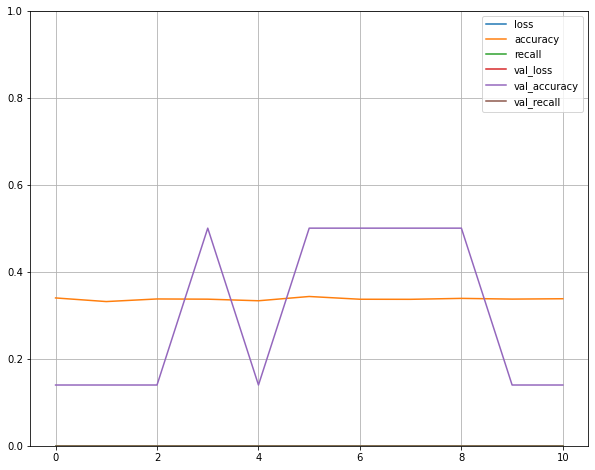

Normalized confusion matrix
[[0.0726257  0.55307263 0.37430168 0.        ]
 [0.         0.83333333 0.16666667 0.        ]
 [0.0203125  0.684375   0.2953125  0.        ]
 [0.046875   0.63616071 0.31696429 0.        ]]


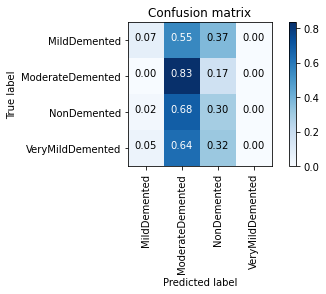

In [110]:
history_aug_df = pd.DataFrame(history_aug.history)
history_aug_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = model_aug.predict_classes(x_test)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices, normalize=True)

Even with Augmented data a basic nerual network model still does not perform well. Based on the confusion matrix it now just seems to guess only the extreme classes. However, it can serve as a baseline for more complex models going forward.

### Convoluted Nerual Network

Image classification is usually more accurate using convolution and pooling. We ran a simple CNN model before attempting more complex models as a means for comparison.

#### CNN with non-augmented images

In [58]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(4, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

#dont forget to change
history = cnn.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2986016   
_________________________________________________________________
dense_31 (Dense)             (None, 4)               

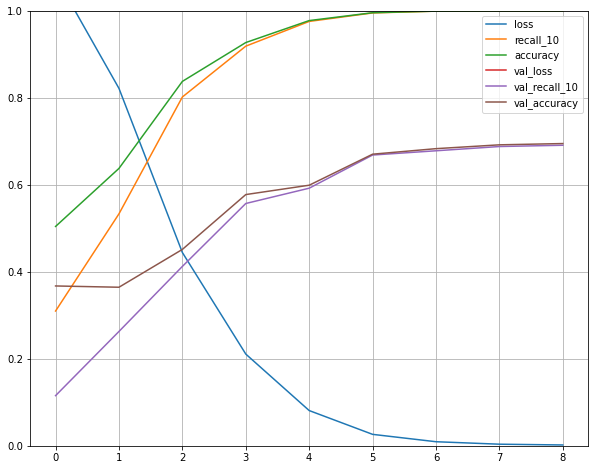

Normalized confusion matrix
[[0.22905028 0.         0.54748603 0.22346369]
 [0.41666667 0.08333333 0.16666667 0.33333333]
 [0.040625   0.         0.828125   0.13125   ]
 [0.015625   0.         0.47098214 0.51339286]]


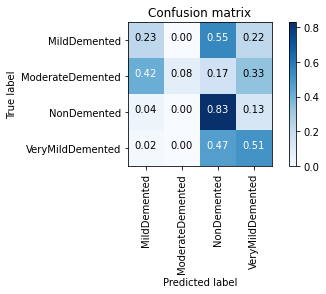

In [109]:
history_cnn_df = pd.DataFrame(history.history)
history_cnn_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices,normalize=True)

CNN performs much better correctly identifying some of each class and increased accuracy and recall. However, the model still does not perform significantly better than random guessing

#### Visualizing what features the convolution neural network is identifying

In [98]:
# Select a moderately demedted image that was correctly identified by the model
a= load_img('./Alzheimer_s Dataset/test/ModerateDemented/27.jpg',target_size=(224,224))
a_array = np.array([img_to_array(a)])

# have the model predict the class
cnn.predict_classes(a_array)

array([1])

Model correctly predicts moderately demented (class 1) for this image. Breaking down what it is doing layer by layer:

conv2d_10 (3, 3, 3, 64)
64
conv2d_11 (3, 3, 64, 32)
32
(1, 111, 111, 64)


/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


(1, 109, 109, 32)
(1, 54, 54, 32)
(1, 93312)
(1, 32)
(1, 4)


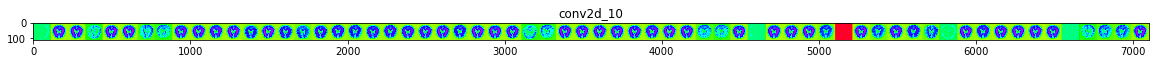

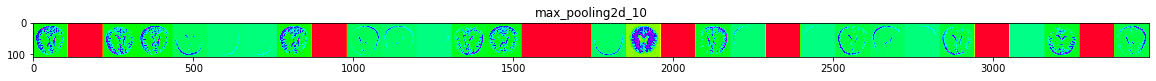

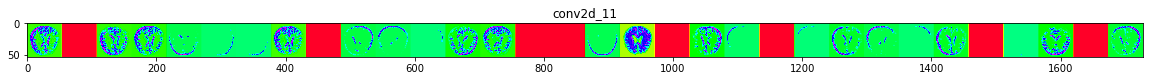

In [100]:
# get layer weights and filters from model
for layer in cnn.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        axis_x=1

#use image above to run through model
img_path='./Alzheimer_s Dataset/test/ModerateDemented/27.jpg' 

#create visualization model to demonstrate what features CNN is learning 
#at each layer
successive_outputs = [layer.output for layer in cnn.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = cnn.input, outputs = successive_outputs)

img = load_img(img_path, target_size=(224, 224)) 

x   = img_to_array(img)                           # Numpy array with shape (224, 224, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255.0

# Run image through visualization model
successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in cnn.layers]

# display representations at each layer
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Isolate only the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile images in matrix
    display_grid = np.zeros((size, size * n_features))
    
    #create grid
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='gist_rainbow' )
    
    plt.savefig(f'./images/cnn_basic_{layer_name}.png')

Based on the above, it looks like the model is identifying features such as the atrophy in the cerebral cortext. Therefore, a quality classifier may need  more complex model architecture using transfer learning to highlight more detailed features. This is attempted in the transfer learning notebook

#### CNN with Augmented Images

In [103]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

#model architecture
cnn_aug = models.Sequential()
cnn_aug.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224,  3),use_bias=True))
cnn_aug.add(layers.MaxPooling2D((2, 2)))
cnn_aug.add(layers.Conv2D(32, (3, 3), activation='relu',use_bias=True))
cnn_aug.add(layers.MaxPooling2D((2, 2)))
cnn_aug.add(layers.Flatten())
cnn_aug.add(layers.Dense(32, activation='relu'))
cnn_aug.add(layers.Dense(4, activation='softmax'))

cnn_aug.summary()

cnn_aug.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

#dont forget to change
history_cnn_aug = cnn_aug.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))
score = cnn_aug.evaluate(test_images, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2986016   
_________________________________________________________________
dense_41 (Dense)             (None, 4)               

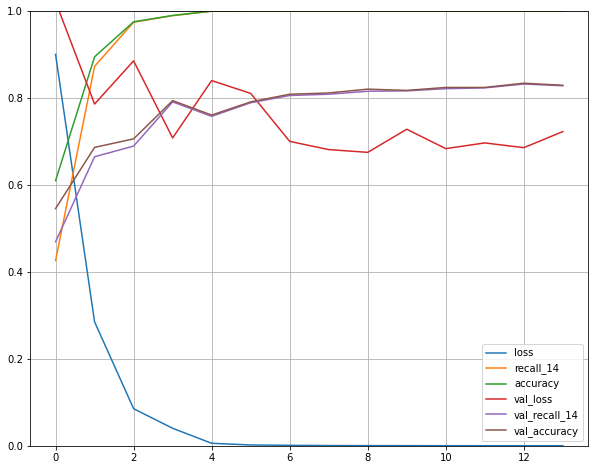

Normalized confusion matrix
[[0.36312849 0.01117318 0.32960894 0.29608939]
 [0.25       0.33333333 0.08333333 0.33333333]
 [0.1359375  0.0453125  0.6109375  0.2078125 ]
 [0.09821429 0.05803571 0.265625   0.578125  ]]


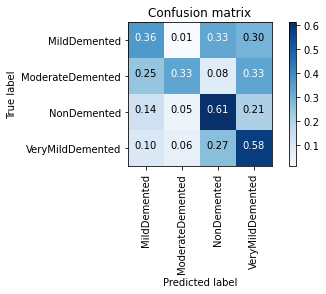

In [108]:
history_cnn_aug_df = pd.DataFrame(history_cnn_aug.history)
history_cnn_aug_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

y_pred = cnn_aug.predict_classes(test_images)

confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices,normalize=True)

Although the overall accuracy and recall decreased when using augmented data, the individual accuracy and recall for the minority classes improved. However, this model doesn't distinguish well between similar classes (mild/veryMild and veryMild/nonDemented)

conv2d_16 (3, 3, 3, 64)
64
conv2d_17 (3, 3, 64, 32)
32
(1, 111, 111, 64)
(1, 109, 109, 32)
(1, 54, 54, 32)
(1, 93312)
(1, 32)
(1, 4)


/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


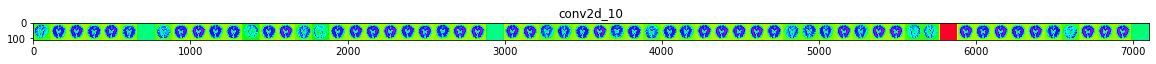

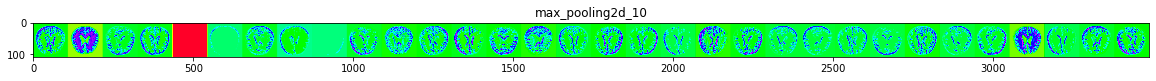

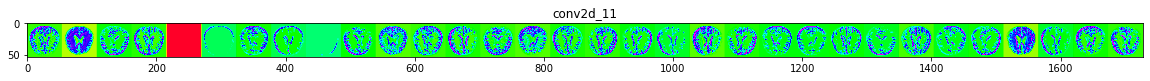

In [117]:
# get layer weights and filters from model
for layer in cnn_aug.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        axis_x=1

#use image above to run through model
img_path='./Alzheimer_s Dataset/test/ModerateDemented/27.jpg' 

#create visualization model to demonstrate what features CNN is learning 
#at each layer
successive_outputs = [layer.output for layer in cnn_aug.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = cnn_aug.input, outputs = successive_outputs)

img = load_img(img_path, target_size=(224, 224)) 

x   = img_to_array(img)                           # Numpy array with shape (224, 224, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255.0

# Run image through visualization model
successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in cnn.layers]

# display representations at each layer
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Isolate only the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile images in matrix
    display_grid = np.zeros((size, size * n_features))
    
    #create grid
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='gist_rainbow' )

Similar to previously layer analysis, we see the model looking for atrophy in along the grey matter of the cerebral cortext.